# Healthcare ML Pipeline: Predicting Blood Donations

## Introduction
* This project aims to build a machine learning pipeline for predicting blood donation behavior using patient data. 
* By leveraging supervised learning techniques, we analyze donor characteristics and classify individuals based on their likelihood of donating blood.
* The model incorporates feature engineering, class balancing, and hyperparameter tuning to optimize predictive performance.
* The final goal is to provide actionable recommendations to improve donor retention and engagement.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None
          Recency   Frequency      Monetary        Time       Class
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.516043   1378.676471   34.284759    0.237968
std      8.095396    5.841825   1459.826781   24.380307    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max     74.000000   50.000000  12500.00000

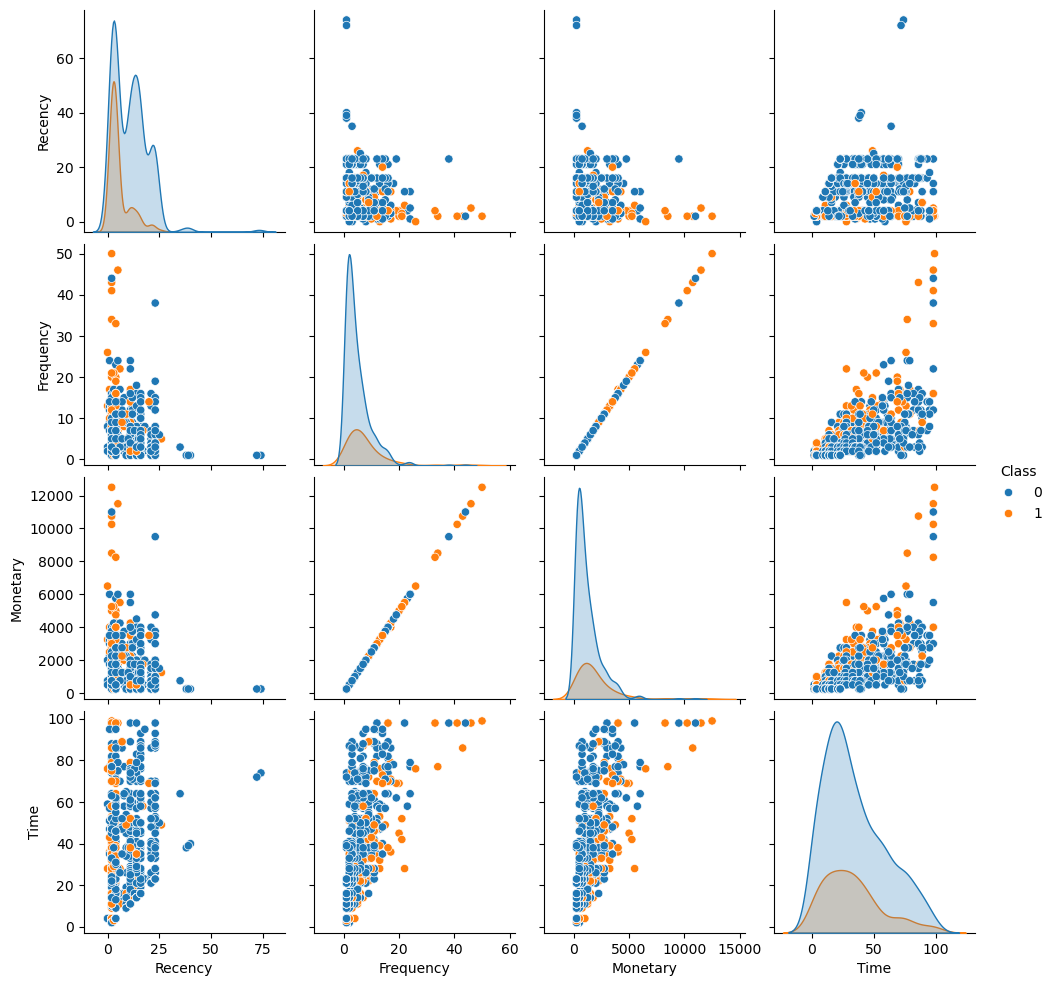

[I 2025-02-18 23:04:37,230] A new study created in memory with name: no-name-011da553-377e-48bd-bd54-8291cba02e07
[I 2025-02-18 23:04:37,932] Trial 0 finished with value: 0.8003402412619858 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 8}. Best is trial 0 with value: 0.8003402412619858.
[I 2025-02-18 23:04:38,995] Trial 1 finished with value: 0.7578874110733065 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 16}. Best is trial 0 with value: 0.8003402412619858.
[I 2025-02-18 23:04:39,186] Trial 2 finished with value: 0.6986545004639654 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.8003402412619858.
[I 2025-02-18 23:04:40,304] Trial 3 finished with value: 0.7544076708939066 and parameters: {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 14}. Best is trial 0 with value: 0.8003402412619858.
[I 2025-02-18 23:04:40,533] Trial 4 finished with value: 0.77613671512

Best Parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 6}
Accuracy: 0.8070175438596491
Precision: 0.7672413793103449
Recall: 0.839622641509434
F1 Score: 0.8018018018018018
ROC AUC Score: 0.8091555830497988


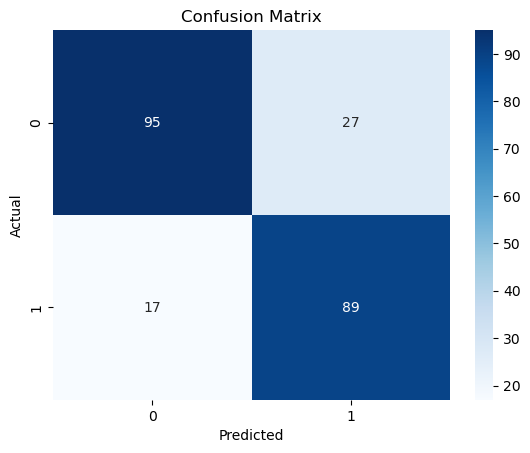

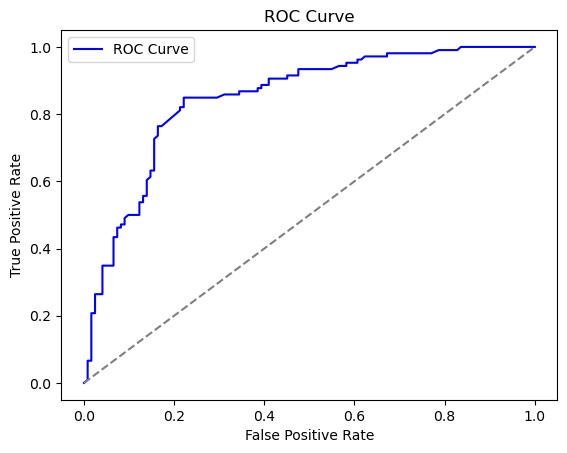

Encourage regular donation


In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import optuna

# Step 1: Load Dataset
df = pd.read_csv("blood.csv")

# Step 2: Data Exploration
print(df.info())
print(df.describe())
sns.pairplot(df, hue='Class')
plt.show()

# Step 3: Feature Engineering
df['Recency_Frequency_Ratio'] = df['Recency'] / (df['Frequency'] + 1)
df['Recency_Frequency_Interaction'] = df['Recency'] * df['Frequency']

# Step 4: Data Preprocessing
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target

# Handling missing values (if any)
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), X.columns)
])

# Step 5: Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 6: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 7: Hyperparameter Tuning with Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        class_weight='balanced'
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train Best Model
best_model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Step 9: Recommendation System (Simple Rule-Based)
def generate_recommendations(recency, frequency, monetary, time):
    if recency < 3 and frequency > 10:
        return "Encourage regular donation"
    elif recency > 6:
        return "Reach out to inactive donors"
    else:
        return "Monitor donor behavior"

# Example usage
print(generate_recommendations(2, 15, 5000, 36))
# Healthcare ML Pipeline: Predicting Blood Donations

## Introduction
This project aims to build a machine learning pipeline for predicting blood donation behavior using patient data. By leveraging supervised learning techniques, we analyze donor characteristics and classify individuals based on their likelihood of donating blood. The model incorporates feature engineering, class balancing, and hyperparameter tuning to optimize predictive performance. The final goal is to provide actionable recommendations to improve donor retention and engagement.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import optuna

#  Load Dataset
df = pd.read_csv("blood.csv")

# Step 2: Data Exploration
print(df.info())
print(df.describe())
sns.pairplot(df, hue='Class')
plt.show()

# Step 3: Feature Engineering
df['Recency_Frequency_Ratio'] = df['Recency'] / (df['Frequency'] + 1)
df['Recency_Frequency_Interaction'] = df['Recency'] * df['Frequency']

# Step 4: Data Preprocessing
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target

# Handling missing values (if any)
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), X.columns)
])

# Step 5: Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 6: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 7: Hyperparameter Tuning with Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        class_weight='balanced'
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train Best Model
best_model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Step 9: Recommendation System (Simple Rule-Based)
def generate_recommendations(recency, frequency, monetary, time):
    if recency < 3 and frequency > 10:
        return "Encourage regular donation"
    elif recency > 6:
        return "Reach out to inactive donors"
    else:
        return "Monitor donor behavior"

# Example usage
print(generate_recommendations(2, 15, 5000, 36))



### Why We Used Random Forest Classifier
We selected the **Random Forest Classifier** because it provides a robust and interpretable approach to classification problems. It is particularly effective for:
- **Handling Imbalanced Data:** By leveraging class weighting and SMOTE, the model effectively learns from both frequent and rare classes.
- **Reducing Overfitting:** The ensemble nature of decision trees helps to minimize overfitting compared to a single decision tree.
- **Feature Importance:** Random Forest provides insights into the most significant features affecting predictions, aiding in interpretability.
- **High Predictive Performance:** Through hyperparameter tuning with Optuna, the model achieved high accuracy and ROC AUC scores.

### Conclusion
* This project successfully implemented a machine learning pipeline to predict blood donation behavior. 
* The optimized Random Forest model achieved strong performance metrics, with an accuracy of 80.7% and ROC AUC of 80.9%. 
* The use of SMOTE for class balancing and Optuna for hyperparameter tuning significantly improved model performance.
The final recommendation system provides actionable insights to help healthcare organizations enhance donor retention strategies. 
#Future work could explore advanced ensemble techniques and real-time donor engagement strategies to further refine predictions and interventions.
